<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [4103]:
%%capture
pip install pyswarms

In [4104]:
%%capture
pip install scipy

In [4105]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps

In [4106]:
!dpkg-reconfigure locales

Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


In [4107]:
# Install locale pt_BR
!/usr/share/locales/install-language-pack pt_BR

Generating locales (this might take a while)...
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.


In [4108]:
print(locale.getlocale())

('pt_BR', 'ISO8859-1')


In [4109]:
locale.setlocale(locale.LC_ALL, 'pt_BR.iso88591')

'pt_BR.iso88591'

In [4110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4111]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 15000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 730 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

VALOR_DIMENSOES = int(DIAS_OBSERVADOS / 30)

ALGORITMO = ('pso')

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_{ALGORITMO}/'
NOME_ARQUIVO_PRINCIPAL = f'melhor_custo_{ALGORITMO}_quarto_cenario'
NOME_ARQUIVO_TEMPO_SEVERIDADE = '_tempo_severidade'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO = '04'

In [4112]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        for i in range(len(self.T) - 1):
            for tt in range(int(self.T[i]), int(self.T[i + 1])):
                b = tt - self.fator[0][i] * self.T[i]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))
            # Adiciona nan ao final do ciclo
            self.u.append(float('nan'))

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [4113]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [4114]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [4115]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [4116]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [4117]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [4118]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [4119]:
# Função custo de manutenção baseada severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {1.0: 400.0000}
    custos = [dist.get(si, CMP) for si in s]
    custo_total = np.sum(custos)
    return custo_total

In [4120]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {0.5: 2000, 1.0: 3000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.20 or si > 1.0 else np.interp(si, [0.5, 1.0], [2000, 3000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [4121]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/cenario{CENARIO}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,1.0,182
1,1309,1,7,0,1.0,366
2,1778,1,7,0,1.0,547
3,2342,1,10,0,1.0,731
4,3254,1,14,0,1.0,912




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [4122]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [4123]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return (-1)*fitness

In [4124]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2023-12-28 19:22:48,189 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-.0839
2023-12-28 19:22:48,354 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.08391496819876343, best pos: [148.78429629   1.0014883    0.55032627]


In [4125]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 148.78429628929626
beta: 1.0014883044944407
theta: 0.5503262709372889

Tempo de Convergência para a primeira etapa: 0.011978387832641602 segundos


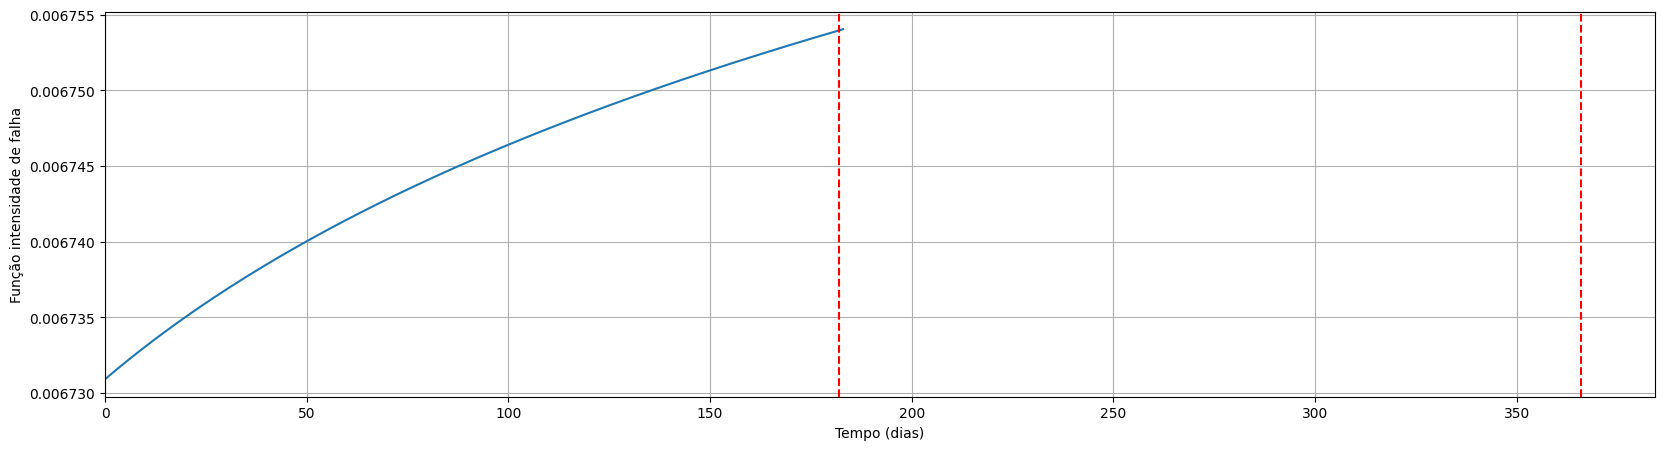

Fator ajuste:  [0.4828472337947568, 0.4828472337947568, 0.4828472337947568, 0.4828472337947568, 0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.4828472337947568, 0.28086665617199813, 0.4828472337947568, 0.28086665617199813, 0.4828472337947568, 0.4828472337947568, 0.4828472337947568]


In [4126]:
lamb = 148.8236099092524
beta = 1.003177327961337
theta = 0.6594169622308468

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [4127]:
# Configurar a formatação da moeda
def format_currency(value):
    return locale.currency(value, grouping=True)

In [4128]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.5, 3:0, 5:0, 7:1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo

    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [4129]:
num_particles = 100
max_iterations = 100
dimensions = VALOR_DIMENSOES
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([1.3] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-12-28 19:22:49,850 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=332



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 7, 62, 395, 601, 638]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.04658092065663886, 0.41526717432193916, 2.661477041997987, 4.054234280860942, 4.304520068376842, 4.9270743405893285]
Custo =  1019.5185172669584


Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 248, 395, 518, 603]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 1.6691082871695793, 2.6608792175002645, 3.492195094715754, 4.067022586941611, 4.926372693172696]
Custo =  583.6809845367541


Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 90, 

pyswarms.single.global_best:  27%|██▋       |27/100, best_cost=217



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 67, 303, 335, 480]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.4490572532238496, 2.0393618683951376, 2.2553742561149677, 3.2350651767571446, 4.926349817005496]
Custo =  628.3125368781514


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 67, 303, 333]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.4490572532238496, 2.0393618683951376, 2.241870781969792, 4.926816552451269]
Custo =  514.344432228608


Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 65, 151, 270, 303, 450]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fa

pyswarms.single.global_best:  44%|████▍     |44/100, best_cost=216



Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 543]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813]
Media de falhas:  [0, 3.6636506952865306, 4.92782111570992]
Custo =  216.98829314884847


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 93, 517, 543]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.6239680304490293, 3.4857929531578726, 3.661581177672518, 4.926801444765957]
Custo =  518.6289727966137


Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 92, 542]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.6172374944235904, 3.6549541607678284, 4.926938182957578]
Custo =  340.20372984373006


N

pyswarms.single.global_best:  60%|██████    |60/100, best_cost=214



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 125, 150, 423, 691]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.8394550733198309, 1.007619102367586, 2.850398758127022, 4.663027026201163, 4.926955937490283]
Custo =  667.9195952718142


Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 32, 300, 424, 518, 695]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0194765330451716, 2.8569612876586414, 3.4923173577062387, 4.689694023188855, 4.9265546140485545]
Custo =  782.8439203170084


Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 33,

pyswarms.single.global_best:  77%|███████▋  |77/100, best_cost=214

Custo =  329.1100146040175


Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 302]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813]
Media de falhas:  [0, 2.0338157803014214, 4.9266346075928364]
Custo =  213.69659123882246


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 121, 302, 510]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.8125085445645923, 2.0324332766714384, 3.437852340069234, 4.926262723392256]
Custo =  450.94273996582024


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 123, 154, 303]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.8259814608864131, 1.03452

pyswarms.single.global_best:  93%|█████████▎|93/100, best_cost=214



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 304, 691]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 2.0473276961864384, 4.662633192342591, 4.926562103631712]
Custo =  366.9279658103695


Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 303]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813]
Media de falhas:  [0, 2.040571702821598, 4.926635096031422]
Custo =  213.68686189402604


Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 303]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813]
Media de falhas:  [0, 2.040571702821598, 4.926635096031422]
Custo =  213.68686189402604


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 157, 303, 515]
Severidade

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=214
2023-12-28 19:22:51,147 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168946 1.0950471  0.9121329  0.82644253 0.26368849 0.30484624
 0.45691385 0.33621851 0.33364336 0.32535773 1.18549954 0.92204809
 0.21370867 0.88706725 0.41883149 0.98593168 0.68507436 0.99891499
 0.78707387 0.82136794 0.61695697 0.41906422 0.49337788 1.17151966]
2023-12-28 19:22:51,156 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 305, 691]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 2.054083760163639, 4.66263448551005, 4.92656339679917]
Custo =  366.92095950610747


Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 304, 690]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 2.0473276961864384, 4.655864671775483, 4.9265606152326695]
Custo =  365.6587491946378


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,188 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169428 1.09889792 0.91094389 0.74566013 0.26371797 0.30484649
 0.4569653  0.33009882 0.33364291 0.39580371 1.18530344 0.9220443
 0.21382763 0.88716764 0.36550398 0.98192405 0.68509521 0.99902608
 0.78707487 0.4137647  0.61695887 0.41909179 0.49337818 1.17172707]
2023-12-28 19:22:51,191 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 304, 690]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 2.0473276961864384, 4.655864671775483, 4.9265606152326695]
Custo =  365.6587491946378


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,227 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168827 1.09576933 0.91122463 0.80163685 0.26372372 0.30484723
 0.45696878 0.3253419  0.33364294 0.45244187 1.18520775 0.9220473
 0.21386649 0.88532415 0.36920938 0.98539248 0.68509314 0.99899967
 0.78710088 0.37569042 0.61696284 0.41912491 0.49337817 1.1695694 ]
2023-12-28 19:22:51,230 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 30, 303, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2005577402824932, 2.039772220640968, 4.656541486338842, 4.927237429796029]
Custo =  533.4313876028605


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,257 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168314 1.09277961 0.91148068 0.8546638  0.26372731 0.30484774
 0.45697069 0.32320102 0.33364308 0.49424062 1.18513156 0.92205014
 0.2138765  0.88375444 0.37285501 0.98853923 0.68508726 0.99897421
 0.78711656 0.24989216 0.61696509 0.41914552 0.49337815 1.16801238]
2023-12-28 19:22:51,259 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 31, 303, 692]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2072645908255546, 2.0397562850942474, 4.670067250291353, 4.927229110202852]
Custo =  533.9250159151231


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,273 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81167954 1.09019872 0.91178587 0.89903849 0.26372014 0.30484803
 0.45696714 0.32209559 0.33364329 0.51574617 1.18506497 0.92205231
 0.21384896 0.88332626 0.38044658 0.99091663 0.68507909 0.99894062
 0.78712743 0.13415705 0.61696698 0.41915363 0.49337811 1.16691835]
2023-12-28 19:22:51,276 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 33, 94, 303, 517, 694]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 0.6302736439618257, 2.039421951285229, 3.4854318986575894, 4.682802550435596, 4.926430250098635]
Custo =  785.6665318344791


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.8116784  1.08838554 0.91206385 0.91887348 0.26370794 0.30484791
 0.45695851 0.32404382 0.33364348 0.50832792 1.18506942 0.9220532
 0.21380188 0.88312327 0.3927177  0.99260682 0.68507171 0.99890476
 0.78712134 0.01549993 0.61696568 0.41915908 0.49337803 1.16663577]
2023-12-28 19:22:51,294 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 34, 97, 127, 304, 696]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.22738918346191364, 0.650453771326621, 0.8523104008628647, 2.0459691697991307, 4.696608831626252, 4.926702294608054]
Custo =  838.5348518109686


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,305 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81167794 1.0882367  0.91232179 0.91364764 0.26369199 0.30484756
 0.45693758 0.32858776 0.33364364 0.48519997 1.18520143 0.92205395
 0.2137448  0.88297963 0.41100263 0.99331224 0.68506536 0.99887528
 0.78710195 1.25995823 0.616962   0.41916295 0.49337791 1.16661393]
2023-12-28 19:22:51,306 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 35, 304, 698]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.23409866079788857, 2.0464507072942615, 4.710632472853424, 4.927191622989762]
Custo =  536.4828054683557


pyswarms.single.global_best:   0%|          |0/1, best_cost=214



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 35, 156, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.23409866079788857, 1.0477525022176164, 2.052753545852748, 4.9268722696882365]
Custo =  495.6087461596838


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,318 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81167959 1.08813576 0.91254623 0.89168939 0.26367671 0.30484725
 0.45691791 0.3343892  0.33364378 0.45517086 1.18536097 0.92205419
 0.21369004 0.88311402 0.4289673  0.99369387 0.68505999 0.99885844
 0.7870781  0.99369196 0.61695749 0.41916297 0.4933778  1.16660863]
2023-12-28 19:22:51,319 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,329 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168157 1.08815744 0.91265097 0.86601535 0.26366553 0.30484669
 0.45689989 0.34009039 0.33364389 0.41746679 1.1855054  0.92205404
 0.21364218 0.88429352 0.4447021  0.99348889 0.68505609 0.99885044
 0.78705578 0.60292941 0



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 35, 151, 305, 450, 510]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.23409866079788857, 1.014058116665109, 2.0527567408763847, 3.0322212863047495, 3.4377762094485678, 4.9261865927715895]
Custo =  750.1405383181568


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,341 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168511 1.0885309  0.91266694 0.83704773 0.26365876 0.30484609
 0.4568839  0.34473258 0.33364395 0.35778963 1.18563407 0.92205359
 0.2136116  0.88603283 0.45871912 0.99145478 0.68505273 0.99885907
 0.78703976 0.14265109 0.61695062 0.41911803 0.49337766 1.16935229]
2023-12-28 19:22:51,342 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 34, 306, 450]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.22738918346191364, 2.0599751612621033, 3.0326875995827653, 4.926820088077495]
Custo =  491.3842963838579


pyswarms.single.global_best:   0%|          |0/1, best_cost=214



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 33, 95, 306, 450]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 0.6370006893236866, 2.0596788990355233, 3.0323913373561853, 4.926523825850914]
Custo =  628.3403102972123


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,414 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168914 1.08996415 0.91264475 0.80780403 0.26365737 0.30484556
 0.45687698 0.3483643  0.33364392 0.30072179 1.18574196 0.92205212
 0.21359766 0.8877981  0.46812772 0.98843934 0.6850537  0.99888274
 0.787031   0.98166715 0.61694869 0.41909105 0.49337767 1.17121935]
2023-12-28 19:22:51,416 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=214



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 32, 128, 150, 306, 451, 511, 697]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8591333942191274, 1.007255113245145, 2.059445919589141, 3.038918287041302, 3.4444758343829065, 4.7027287484101254, 4.926055064472996]
Custo =  1114.5163653796449


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169286 1.09222591 0.91247588 0.78242541 0.26366176 0.30484523
 0.45687917 0.34948126 0.33364376 0.2565449  1.18578605 0.92205071
 0.21360212 0.88934154 0.46959708 0.98510226 0.68505784 0.99891267
 0.78702997 0.42938002 0.61694871 0.41906153 0.49337774 1.17295063]
2023-12-28 19:22:51,450 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,467 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169566 1.09448819 0.91226868 0.76202205 0.26367333 0.30484497
 0.4568842  0.34949391 0.33364358 0.22250794 1.18574576 0.92204892
 0.21363076 0.89023068 0.46650219 0.98220662 0.68506243 0.99894011
 0.78703971 1.11574548 0



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 31, 152, 306, 451]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2072645908255546, 1.0208261101419311, 2.0595383103583957, 3.039010677810557, 4.92638201688979]
Custo =  620.1072531018585


2023-12-28 19:22:51,470 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,487 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169777 1.09659217 0.91207892 0.74729052 0.2636881  0.30484484
 0.45689477 0.34789655 0.33364336 0.19548978 1.18567238 0.9220472
 0.21367535 0.89051616 0.45632479 0.9798471  0.68506883 0.99895861
 0.7870584  0.40238779 0.61695023 0.41901355 0.49337791 1.17491857]
2023-12-28 19:22:51,488 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 31, 122, 153, 306, 450]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2072645908255546, 0.8187338103032561, 1.0274507278333056, 2.05942348244516, 3.032135920765822, 4.926268409260551]
Custo =  791.1563212031705


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,500 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169719 1.09812331 0.91192311 0.74024633 0.26370142 0.30484477
 0.45690443 0.34477663 0.33364316 0.17262651 1.18555562 0.92204579
 0.21371947 0.89026745 0.43624323 0.97854507 0.68507476 0.99896468
 0.7870786  1.03830385 0.6169519  0.41899772 0.49337798 1.17464396]
2023-12-28 19:22:51,501 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 31, 93, 153, 305, 450, 512, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2072645908255546, 0.6235505986910177, 1.0274210658766192, 2.052640939541969, 3.0321054849703337, 3.4511825670135785, 4.6552916042847965, 4.925987547741983]
Custo =  1059.3912267709384


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169564 1.09908009 0.91180632 0.74344344 0.26371309 0.30484496
 0.45691589 0.34063256 0.33364302 0.19529412 1.18543762 0.92204486
 0.21375676 0.88942579 0.41759264 0.97851666 0.68508004 0.99896382
 0.78709647 0.26594109 0.61695425 0.41898765 0.49337803 1.17373741]
2023-12-28 19:22:51,514 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 31, 155, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2072645908255546, 1.0410436456717584, 2.0527843923373537, 4.926903116172842]
Custo =  502.4476236930655


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169258 1.09952896 0.91171431 0.75057761 0.26371864 0.3048454
 0.45692601 0.33612406 0.33364292 0.23227829 1.18533811 0.92204413
 0.21377724 0.8882656  0.40116909 0.97954855 0.68508322 0.99895848
 0.78710898 0.85248667 0.61695637 0.41899521 0.49337807 1.17251617]
2023-12-28 19:22:51,527 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 31, 154, 305, 518]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2072645908255546, 1.034304312775792, 2.0527846696679717, 3.492052072774016, 4.926358420549273]
Custo =  618.0071236517607


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,537 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168926 1.09887574 0.9116798  0.75812741 0.26371505 0.30484604
 0.45693406 0.33206922 0.33364296 0.2909287  1.18529118 0.92204429
 0.2137814  0.88687642 0.38843503 0.9823255  0.6850851  0.99894655
 0.78711131 0.07905918 0.61695834 0.41901311 0.49337805 1.17122652]




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 152, 304, 696]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.0208182234674061, 2.0460246977026504, 4.6966643595297715, 4.926757822511574]
Custo =  661.5163804076561


2023-12-28 19:22:51,539 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,549 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168633 1.0975106  0.91177487 0.77761608 0.26370886 0.30484665
 0.45693779 0.32907545 0.33364307 0.35276597 1.18527431 0.92204557
 0.21376917 0.88564398 0.38378529 0.98487465 0.68508531 0.99893366
 0.78711176 0.76081661 0.61696008 0.419034   0.49337802 1.17015377]
2023-12-28 19:22:51,550 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 151, 304, 512]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.014079431826887, 2.046025210940662, 3.451464965479918, 4.926349503082003]
Custo =  616.3294760993301


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,560 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168408 1.09598986 0.9119209  0.80335794 0.26370003 0.30484717
 0.45693823 0.32765416 0.3336432  0.40301609 1.18529358 0.92204727
 0.21374729 0.88481696 0.38301669 0.98734093 0.68508231 0.99892121
 0.78710336 0.08563587 0.61696118 0.41905279 0.49337795 1.16922836]
2023-12-28 19:22:51,561 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 153, 304, 693]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.0275571719147036, 2.0460242465182645, 4.676351017138069, 4.926745806496276]
Custo =  656.7365955594576


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,571 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.8116828  1.0946096  0.91208846 0.82680757 0.26369081 0.3048474
 0.45693765 0.32655248 0.33364334 0.44676492 1.18536915 0.922049
 0.21372205 0.88462235 0.38377189 0.98913895 0.68507733 0.99890939
 0.78709106 0.65267355 0.61696213 0.41907051 0.49337789 1.16875573]
2023-12-28 19:22:51,573 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 33, 91, 153, 304]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 0.6100941649121766, 1.0274192263720745, 2.0458863009756354, 4.926760527562264]
Custo =  649.8836685774561


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,582 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168278 1.09342108 0.91223957 0.84782405 0.2636819  0.30484738
 0.45693417 0.32571981 0.33364346 0.45407705 1.18546967 0.92205038
 0.21369929 0.88500058 0.39433638 0.99044811 0.68507243 0.99889943
 0.78707847 1.16314405 0.61696223 0.41908591 0.49337783 1.16861314]
2023-12-28 19:22:51,584 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 33, 150, 304, 692]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 1.007333423209855, 2.046018411773802, 4.669574289393045, 4.926736149304544]
Custo =  653.7435169787739


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,594 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168462 1.09236352 0.91236867 0.86461631 0.26367507 0.30484706
 0.4569299  0.32802545 0.33364356 0.42374821 1.1855645  0.92205125
 0.21368021 0.88569015 0.40938692 0.99109399 0.68506812 0.99889315
 0.78706695 0.28723402 0.61696186 0.41909769 0.49337778 1.16883199]
2023-12-28 19:22:51,595 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 33, 152, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 1.020810695717058, 2.0527699920442544, 4.926888715879743]
Custo =  498.9685362215277


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,609 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.8116871  1.09204997 0.91245669 0.87390751 0.26367293 0.30484659
 0.45692478 0.33176352 0.3336436  0.37035593 1.18563696 0.9220516
 0.21366305 0.88652982 0.423836   0.9915359  0.68506526 0.99889018
 0.78705702 0.6780851  0.61696022 0.41910334 0.49337777 1.16927665]
2023-12-28 19:22:51,610 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 33, 92, 127, 153, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 0.6168203781679997, 0.8523084620187745, 1.0273678886795756, 2.0525877623449253, 4.926706486180414]
Custo =  851.9886757635859


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,621 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168972 1.0920377  0.91244922 0.87840722 0.26367497 0.30484615
 0.45691862 0.33559351 0.33364362 0.30943341 1.18569222 0.92205136
 0.21365772 0.88730143 0.43543072 0.99108348 0.68506511 0.99888792
 0.78704822 1.0426902  0.61695801 0.41909908 0.49337776 1.17000338]
2023-12-28 19:22:51,622 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 33, 154, 305, 450]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 1.0342885976870433, 2.052768954579223, 3.032233500007588, 4.926365988502317]
Custo =  616.454598137831


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,632 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169204 1.0920382  0.91237573 0.87308032 0.26367963 0.30484576
 0.45691231 0.33905273 0.33364361 0.2555922  1.18573678 0.9220508
 0.21365576 0.8879672  0.44367985 0.98936915 0.68506689 0.99888801
 0.78704476 0.05492492 0.61695595 0.4190854  0.49337776 1.17098501]
2023-12-28 19:22:51,633 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 33, 124, 306, 450]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 0.832190851118063, 2.0595663369650303, 3.0322787752856923, 4.926411263780421]
Custo =  619.6654348853358


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 93, 306, 450]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6235485422323029, 2.0596914934040065, 3.0324039317246685, 4.9265364202193975]
Custo =  630.6556727292162



2023-12-28 19:22:51,643 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169362 1.09254467 0.91229445 0.86570939 0.26368611 0.30484553
 0.45690708 0.34189804 0.33364359 0.21331952 1.18572095 0.92204998
 0.21365566 0.8884324  0.44693865 0.98727115 0.68506933 0.9988903
 0.78704202 0.56298433 0.61695429 0.41907025 0.49337776 1.17188624]
2023-12-28 19:22:51,645 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 124, 306]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8321960025147859, 2.059571488361753, 4.926934661519736]
Custo =  503.6389838489618


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,712 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169388 1.09344289 0.91220104 0.85057797 0.26369211 0.30484551
 0.45690427 0.34275563 0.33364354 0.20000229 1.18565456 0.9220489
 0.21365708 0.88872792 0.4415684  0.98513626 0.68507185 0.99889608
 0.78704565 1.0280487  0.6169529  0.41905624 0.49337779 1.1726549 ]
2023-12-28 19:22:51,748 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=214



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 154, 306, 510]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.034296276032361, 2.0595294909038016, 3.437936725085831, 4.926347108408852]
Custo =  616.1154593932998


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,876 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169284 1.0946493  0.91211016 0.8324811  0.26369733 0.30484571
 0.4569031  0.34188118 0.33364347 0.19516674 1.18555579 0.92204778
 0.21366299 0.88879275 0.43033694 0.98328936 0.68507452 0.99890446
 0.78705416 0.11735995 0.61695263 0.41904385 0.49337785 1.17309219]
2023-12-28 19:22:51,889 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:51,950 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169152 1.09580138 0.91203189 0.81441675 0.26369965 0.304846
 0.45690437 0.34070011 0.33364341 0.20043387 1.18545804 0.92204678
 0.21367701 0.88859782 0.41977799 0.98181353 0.68507688 0.99891348
 0.78706295 0.64400624 0.6



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 95, 306, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6370026227586464, 2.059680832470483, 4.656184751692069, 4.926880695149256]
Custo =  664.029194147544


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,061 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168973 1.09677032 0.91198    0.80107014 0.26370133 0.30484632
 0.4569077  0.33902912 0.33364334 0.23318204 1.18537727 0.92204614
 0.21369709 0.88805034 0.41001229 0.98144232 0.68507863 0.99892171
 0.78707365 1.135628   0.61695325 0.41902954 0.49337794 1.17333139]
2023-12-28 19:22:52,065 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,091 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168809 1.09758988 0.91194015 0.79532422 0.26369975 0.3048466
 0.45691097 0.3369225  0.33364328 0.28687585 1.18533381 0.92204607
 0.21371739 0.88730496 0.40276191 0.98211595 0.68508    0.99892865
 0.78708332 0.2471068  0.61695481 0.41902921 0.49337797 1.17309609]
2023-12-28 19:22:52,096 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,119 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168674 1.09809683 0.91191101 0.79032175 0.26369509 0.30484679
 0.45691419 0.33482142 0.33364325 0.34587455 1.18529526 0.92204611
 0.21373532 0.88662057 0.3967626  0.98358776 0.68508014 0.99893374
 0.78709068 0.70199686 0.61695628 0.41903394 0.49337799 1.17245672]
2023-12-28 19:22:52,123 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 91, 127, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6100955642622395, 0.8523094952952581, 2.0527216542120765, 4.926840378047565]
Custo =  672.4247650859076


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,149 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168576 1.09825088 0.91193769 0.79597503 0.26368947 0.30484686
 0.45691702 0.33320414 0.33364325 0.39630904 1.18526718 0.92204664
 0.21374537 0.88608001 0.39226575 0.98559338 0.6850798  0.99893537
 0.78709712 1.14332103 0.61695767 0.41903826 0.49337799 1.17160128]
2023-12-28 19:22:52,154 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,176 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168559 1.09742997 0.91200794 0.8024642  0.26368423 0.30484682
 0.45691917 0.33260876 0.33364328 0.42263375 1.18528194 0.92204719
 0.21374697 0.88587328 0.39405877 0.98748748 0.68507928 0.99893577
 0.78709599 0.18063253 0.6169588  0.41904928 0.49337797 1.17080786]
2023-12-28 19:22:52,181 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 33, 158, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 1.061246253913924, 2.0527676156337376, 4.926886339469226]
Custo =  498.70967150861713


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,207 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168618 1.096453   0.91209825 0.81321472 0.26368061 0.30484669
 0.45691955 0.33313973 0.33364333 0.41922634 1.18532578 0.92204771
 0.21373913 0.88600035 0.39895859 0.98885404 0.68507795 0.9989302
 0.78709085 0.60040126 0.61695961 0.41906182 0.49337795 1.17022719]
2023-12-28 19:22:52,212 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 33, 305, 693]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 2.0532352001313017, 4.676806825289469, 4.927201614647676]
Custo =  531.4750875939039


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,236 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168732 1.09521166 0.91218785 0.82538496 0.26367753 0.30484649
 0.45691974 0.33372226 0.33364338 0.39214845 1.18539836 0.92204823
 0.21372843 0.88637928 0.40783586 0.98990267 0.68507616 0.99892201
 0.78708485 1.03655915 0.61695957 0.41907347 0.49337791 1.16997732]
2023-12-28 19:22:52,238 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 33, 95, 151, 305, 511]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 0.6370006893236866, 1.013941889685704, 2.0526405138969794, 3.444563992093804, 4.926211466223466]
Custo =  766.4131828484933


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,269 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168877 1.09405957 0.91225392 0.83643081 0.26367663 0.30484632
 0.45691966 0.33499537 0.33364343 0.36606509 1.18549252 0.92204867
 0.213716   0.88680428 0.41742057 0.99006964 0.6850742  0.99891344
 0.78707689 0.11470986 0.61695911 0.41908376 0.49337787 1.17003084]
2023-12-28 19:22:52,272 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 33, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 2.0532352001313017, 4.92735392396679]
Custo =  375.4736219110209


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,297 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169018 1.09316983 0.9123067  0.84583288 0.26367762 0.30484616
 0.45691808 0.33626569 0.33364346 0.34008686 1.18557886 0.92204899
 0.21370363 0.88723544 0.42629292 0.98940728 0.68507246 0.9989058
 0.7870691  0.57867509 0.61695811 0.41908974 0.49337784 1.17027789]
2023-12-28 19:22:52,300 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 33, 305, 513, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.2206803331930953, 2.0532352001313017, 3.458685263164497, 4.656031763697433, 4.92672770715462]
Custo =  644.5786678988945


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,328 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169131 1.09271635 0.91231839 0.85121953 0.26368164 0.30484601
 0.45691543 0.33740189 0.33364348 0.31265331 1.18565351 0.92204917
 0.21369304 0.88760294 0.43353007 0.98869509 0.6850711  0.99890128
 0.7870622  1.04550459 0.61695687 0.41909235 0.49337782 1.17063455]
2023-12-28 19:22:52,331 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,359 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169208 1.09237463 0.91232362 0.85410112 0.26368667 0.30484591
 0.45691303 0.33814475 0.33364348 0.28899908 1.18571794 0.92204918
 0.21368582 0.88789851 0.43984669 0.98764718 0.68507063 0.99890052
 0.78705662 0.11462993 0.61695576 0.41909446 0.49337781 1.17106583]




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 92, 305, 513]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6168219136445355, 2.052942760163065, 3.4583928231962604, 4.926514396996786]
Custo =  629.0397616200227


2023-12-28 19:22:52,363 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,386 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169276 1.09228659 0.91228816 0.85436556 0.2636913  0.30484592
 0.45691099 0.33833691 0.33364347 0.27691823 1.18571621 0.92204912
 0.21368234 0.8879418  0.44373453 0.98620808 0.68507091 0.99890259
 0.78705316 0.64768075 0.61695507 0.41909592 0.4933778  1.17157419]
2023-12-28 19:22:52,388 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 691]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.6632804122400575, 4.927209323529178]
Custo =  530.5852452254516


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,415 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169322 1.09234548 0.91223051 0.851959   0.26369484 0.30484593
 0.45690972 0.33845171 0.33364343 0.26706931 1.18568432 0.92204887
 0.2136853  0.88775212 0.44165184 0.9848445  0.68507201 0.99890533
 0.78705558 1.17145383 0.6169549  0.41909425 0.4933778  1.1720188 ]
2023-12-28 19:22:52,422 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 510]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 3.4384107791958973, 4.926821162518919]
Custo =  492.8674175486686


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,452 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169268 1.09250182 0.91214945 0.84356569 0.26369634 0.30484595
 0.45690874 0.33809205 0.33364339 0.27259106 1.18561665 0.92204858
 0.21368903 0.88747783 0.43628162 0.98379493 0.68507347 0.99890908
 0.78705998 0.29481106 0.61695518 0.41909    0.49337782 1.17227205]
2023-12-28 19:22:52,454 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,470 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169186 1.09311529 0.91207329 0.83382148 0.26369548 0.304846
 0.45690899 0.3373783  0.33364334 0.29139174 1.18552176 0.9220483
 0.21369398 0.88720449 0.43141184 0.98302141 0.68507498 0.99891357
 0.78706521 0.7257608  0.61695565 0.41907893 0.49337784 1.17231873]
2023-12-28 19:22:52,472 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 151, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.014079431826887, 2.0527780560381625, 4.926896779873651]
Custo =  500.764343464712


pyswarms.single.global_best:   0%|          |0/1, best_cost=214



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,528 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169097 1.0938389  0.91201549 0.82435028 0.26369351 0.30484608
 0.45691    0.33662716 0.3336433  0.30937352 1.18543355 0.922048
 0.21370273 0.8869506  0.42488667 0.98249317 0.68507625 0.99891778
 0.78707195 1.13651121 0.61695624 0.41906847 0.49337786 1.17212868]
2023-12-28 19:22:52,530 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,560 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168999 1.09457116 0.91196862 0.81632204 0.2636904  0.30484616
 0.45691114 0.33585104 0.33364328 0.32756573 1.18537361 0.92204773
 0.21371181 0.88674414 0.41850208 0.98262834 0.68507722 0.99892108
 0.78707828 0.11308451 0.6



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 127, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8523987568143254, 2.0528109157311434, 4.926929639566632]
Custo =  503.19592119852126


pyswarms.single.global_best:   0%|          |0/1, best_cost=214



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 32, 97, 152, 305, 514]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.650457778202124, 1.0206802260894188, 2.052639522416615, 3.464852953357104, 4.926211536142091]
Custo =  767.5407971607088


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,582 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.811689   1.09531224 0.91195435 0.80911293 0.26368758 0.30484623
 0.45691295 0.33519452 0.33364328 0.343562   1.18534105 0.9220476
 0.21371939 0.88664765 0.41283797 0.98349683 0.68507798 0.99892395
 0.78708287 0.52043363 0.61695737 0.41905012 0.49337791 1.17165357]
2023-12-28 19:22:52,597 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,618 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168812 1.09592197 0.91197426 0.80655185 0.26368507 0.30484629
 0.4569147  0.33487782 0.33364328 0.35535021 1.18535566 0.92204749
 0.21372334 0.8865972  0.40798384 0.98443997 0.6850778  0.99892441
 0.78708669 0.9601729  0.



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 691]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.6632804122400575, 4.927209323529178]
Custo =  530.5852452254516


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 123, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8254621429249835, 2.0528204548432853, 4.926939178678774]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,660 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168765 1.09639298 0.91203015 0.80537315 0.26368354 0.30484635
 0.45691617 0.33462048 0.3336433  0.36126041 1.18540102 0.92204743
 0.21372673 0.88660075 0.40416213 0.98539114 0.68507663 0.9989248
 0.78708799 0.05188417 0.61695807 0.41904206 0.49337793 1.17122456]
2023-12-28 19:22:52,662 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  503.8627972093276


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 90, 154, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6033694977695013, 1.034159147056322, 2.0526395039485017, 4.92675822778399]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168754 1.09646732 0.91210286 0.80487736 0.26368268 0.30484638
 0.45691704 0.33460048 0.33364332 0.36259583 1.1854642  0.92204746
 0.21372573 0.88664803 0.40508574 0.98634297 0.68507546 0.99892362
 0.7870876  0.42099976 0.61695795 0.41904012 0.49337793 1.17113242]
2023-12-28 19:22:52,698 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  650.7686794118949


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,728 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.8116877  1.09612251 0.91216867 0.8048004  0.26368284 0.30484639
 0.45691738 0.33475247 0.33364334 0.35515242 1.18552568 0.92204756
 0.21372329 0.88672127 0.40829079 0.98717311 0.68507435 0.99892024
 0.78708455 0.85430994 0.6169577  0.41904001 0.49337792 1.17116303]
2023-12-28 19:22:52,733 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 126, 305, 693]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8456643112369224, 2.0528131830404823, 4.67638480819865, 4.926779597556857]
Custo =  659.3557186196865


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 513]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 3.45870058072564, 4.926822154526166]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,763 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168787 1.0955305  0.91221957 0.80835523 0.26368463 0.30484638
 0.45691759 0.33528511 0.33364336 0.34372169 1.18557983 0.92204773
 0.21371809 0.8867893  0.41200716 0.98779657 0.68507336 0.99891572
 0.78708075 1.24081152 0.61695744 0.41904011 0.4933779  1.17129288]
2023-12-28 19:22:52,767 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  492.8542993223188


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168815 1.09496319 0.91225077 0.8126893  0.26368688 0.30484637
 0.45691739 0.33578938 0.33364338 0.33235133 1.18562156 0.92204791
 0.21371209 0.8868864  0.41634657 0.98811792 0.68507255 0.99891146
 0.78707709 0.24526113 0.6169572  0.41904523 0.49337788 1.17146618]
2023-12-28 19:22:52,801 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 122, 153, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8187284822742165, 1.0274453998042659, 2.0526652734696156, 4.926783997305105]
Custo =  671.7988444285531


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,829 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168852 1.09445926 0.91226364 0.81998463 0.263689   0.30484634
 0.45691621 0.3363286  0.33364339 0.32050465 1.18564333 0.92204811
 0.21370623 0.88702518 0.42085748 0.98838566 0.6850722  0.99890831
 0.78707299 0.57491418 0.61695697 0.41905112 0.49337787 1.17163277]
2023-12-28 19:22:52,834 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 98, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6571857507535187, 2.052911577058715, 4.927030300894204]
Custo =  510.77958944033793


pyswarms.single.global_best:   0%|          |0/1, best_cost=214



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 515]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 3.47222736671008, 4.9268229313253284]
Custo =  492.84973070055213


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,861 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168885 1.0941659  0.91224523 0.82829308 0.2636908  0.30484629
 0.456915   0.3367946  0.3336434  0.31054537 1.18566263 0.92204829
 0.21370135 0.88715961 0.42446193 0.98852307 0.68507204 0.9989065
 0.7870695  0.89199158 0.61695676 0.41905745 0.49337785 1.1717748 ]
2023-12-28 19:22:52,863 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,895 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168927 1.09405304 0.91221398 0.83558636 0.26369195 0.30484623
 0.45691379 0.3371876  0.3336434  0.30429455 1.18567315 0.92204842
 0.21369906 0.88725337 0.42650033 0.98816505 0.68507213 0.99890522
 0.78706713 1.16998123 0.6169566  0.41906329 0.49337784 1.17186234]
2023-12-28 19:22:52,900 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  377.33006161862255


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 92, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6168219136445355, 2.052942760163065, 4.927061483998553]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,927 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168969 1.09421907 0.91216638 0.84148012 0.26369254 0.30484617
 0.45691271 0.33749242 0.3336434  0.30462958 1.18563904 0.92204849
 0.21369816 0.88732095 0.42736465 0.98745883 0.68507232 0.99890596
 0.78706654 0.06571635 0.61695648 0.41906871 0.49337784 1.17192819]
2023-12-28 19:22:52,931 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  513.5155239163264


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 518]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 3.492517920798489, 4.926824268573746]


pyswarms.single.global_best:   0%|          |0/1, best_cost=214

Custo =  492.849127595415


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,959 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169006 1.09449405 0.91211933 0.84502209 0.26369253 0.30484614
 0.45691196 0.33776289 0.3336434  0.30617668 1.18557972 0.92204851
 0.2136977  0.88731185 0.42598242 0.98644385 0.68507259 0.99890902
 0.78706653 0.24997307 0.6169564  0.41907235 0.49337784 1.17189116]
2023-12-28 19:22:52,961 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 154, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.034296276032361, 2.052776632924541, 4.9268953567600295]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:52,992 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169038 1.09476131 0.91207766 0.84654134 0.2636925  0.30484613
 0.45691134 0.3378163  0.33364339 0.31331565 1.18550555 0.92204843
 0.2137     0.88729217 0.42271741 0.98544254 0.68507333 0.99891252
 0.78706782 0.42697187 0.61695636 0.41907557 0.49337785 1.1717988 ]
2023-12-28 19:22:52,994 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  500.61634956752476


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255



2023-12-28 19:22:53,020 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169043 1.09503032 0.91205404 0.84370057 0.26369176 0.30484613
 0.45691148 0.33753548 0.33364338 0.32329445 1.18543762 0.92204826
 0.21370227 0.88726318 0.41939274 0.98459004 0.68507401 0.99891595
 0.78706963 0.59524605 0.6169565  0.41907735 0.49337786 1.17169925]
2023-12-28 19:22:53,028 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 32, 94, 120, 305, 516]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6302754464363273, 0.8051904028233118, 2.052757085961062, 3.478497403109211, 4.926329922460075]
Custo =  807.2404643738855


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,058 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81169029 1.09527509 0.91204875 0.83912813 0.26369029 0.30484615
 0.4569118  0.33715215 0.33364337 0.33270372 1.18539443 0.9220481
 0.21370595 0.8872309  0.41629879 0.98415067 0.68507472 0.99891888
 0.78707251 0.77837424 0.61695674 0.41907833 0.49337788 1.17156962]
2023-12-28 19:22:53,062 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=214



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 153, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.0275571719147036, 2.0527770455800534, 4.926895769415542]
Custo =  500.66228632427806


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,085 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168993 1.0954877  0.91205779 0.83365171 0.26368857 0.30484619
 0.45691247 0.33673052 0.33364336 0.33992168 1.18537584 0.92204795
 0.21370935 0.88715485 0.41422563 0.98402243 0.68507534 0.99892105
 0.78707533 0.95349026 0.61695702 0.41907764 0.4933779  1.17144459]
2023-12-28 19:22:53,094 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 123, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]

pyswarms.single.global_best:   0%|          |0/1, best_cost=214


Media de falhas:  [0, 0.21397212893789638, 0.8254621429249835, 2.0528204548432853, 4.926939178678774]
Custo =  503.8627972093276


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168952 1.0956402  0.91207412 0.82822798 0.26368701 0.30484623
 0.45691312 0.33619901 0.33364335 0.34225501 1.18537565 0.92204783
 0.21371233 0.88707935 0.41287469 0.98399931 0.68507565 0.99892262
 0.78707759 1.07978767 0.61695727 0.41907601 0.49337791 1.17133449]
2023-12-28 19:22:53,127 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=214



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 512]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 3.4519372631052265, 4.9268218007073115]
Custo =  492.8578355845147


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,158 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168913 1.09577745 0.91210393 0.82284552 0.263686   0.30484627
 0.45691391 0.33572543 0.33364334 0.34279902 1.18539955 0.92204774
 0.21371501 0.88700973 0.41186428 0.98424063 0.68507565 0.99892226
 0.78707916 1.13568565 0.61695742 0.41907392 0.49337792 1.17124868]
2023-12-28 19:22:53,161 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=214



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 32, 97, 127, 305, 697]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.650457778202124, 0.8523144077383678, 2.0527265666551857, 4.703382077642119, 4.926708393704989]
Custo =  842.9335960431781


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,189 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168882 1.09580351 0.91213107 0.8182437  0.2636855  0.3048463
 0.4569146  0.33537054 0.33364334 0.34290909 1.1854381  0.92204771
 0.21371591 0.88695996 0.41172076 0.98460834 0.68507554 0.9989203
 0.78707945 1.11880596 0.61695744 0.41906964 0.49337792 1.17121742]
2023-12-28 19:22:53,191 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,219 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168861 1.09576226 0.91215566 0.81410809 0.26368591 0.30484633
 0.45691516 0.33523513 0.33364334 0.34062219 1.18548865 0.92204776
 0.21371461 0.88692606 0.41180718 0.98495244 0.68507534 0.99891849
 0.78707923 1.07843948 0.6



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,237 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168861 1.09556283 0.91217412 0.81040609 0.26368686 0.30484633
 0.45691555 0.33540346 0.33364334 0.33547339 1.18553462 0.92204791
 0.2137127  0.88689858 0.41374871 0.98554373 0.68507494 0.99891601
 0.78707895 1.0318655  0.61695729 0.41905951 0.49337791 1.17126925]
2023-12-28 19:22:53,238 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 127, 158, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8523987568143254, 1.061138547051751, 2.0526599087715645, 4.9267786326070535]
Custo =  671.1019828163767


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,292 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168876 1.09523779 0.91218279 0.80914728 0.26368784 0.30484633
 0.45691568 0.33555544 0.33364334 0.32891502 1.18557408 0.92204806
 0.21371094 0.88687893 0.4166738  0.9861035  0.68507447 0.99891362
 0.78707764 0.97797721 0.61695709 0.41905642 0.4933779  1.17136487]
2023-12-28 19:22:53,294 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,335 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168899 1.09492206 0.91217969 0.80978386 0.26368884 0.30484632
 0.45691558 0.33582465 0.33364335 0.32290903 1.18560155 0.92204821
 0.21370914 0.88691731 0.4198058  0.98659692 0.68507404 0.99891176
 0.78707586 0.91090208 0.61695689 0.41905365 0.49337788 1.17147299]
2023-12-28 19:22:53,338 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 120, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8052617652698375, 2.052828448407588, 4.926947172243077]
Custo =  504.4249472838198


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 32, 97, 152, 305, 516]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.650457778202124, 1.0206802260894188, 2.052639522416615, 3.478379839564764, 4.926212358915629]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,365 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168923 1.09465065 0.91217038 0.81391681 0.26368969 0.30484629
 0.4569152  0.33615578 0.33364335 0.31815305 1.18560793 0.92204832
 0.2137075  0.88699529 0.42253416 0.9869059  0.68507369 0.9989104
 0.78707368 0.84637696 0.61695671 0.41905263 0.49337786 1.17157075]
2023-12-28 19:22:53,370 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  767.5378959666172


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168946 1.09446276 0.91215958 0.81782148 0.26369012 0.30484626
 0.45691464 0.33645446 0.33364336 0.3141243  1.18558302 0.9220484
 0.2137062  0.88708383 0.42396789 0.98712236 0.68507344 0.99890923
 0.78707177 0.78396256 0.61695657 0.41905225 0.49337785 1.17164576]
2023-12-28 19:22:53,404 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  377.33006161862255


pyswarms.single.global_best:   0%|          |0/1, best_cost=214



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 158, 305, 511]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.061254227044168, 2.0527755887639816, 3.4446990669608057, 4.926346541090468]
Custo =  615.9979720737558


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,436 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168966 1.09437664 0.91214213 0.82144567 0.26369046 0.30484623
 0.45691403 0.33665565 0.33364337 0.31095188 1.18554564 0.92204841
 0.21370574 0.88715894 0.42503934 0.98709764 0.68507334 0.99890942
 0.78707008 0.73659776 0.61695648 0.41905393 0.49337784 1.17167779]
2023-12-28 19:22:53,437 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,456 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.8116898  1.09447228 0.91212604 0.82602198 0.26369064 0.3048462
 0.45691347 0.33670782 0.33364337 0.31066945 1.18550435 0.92204833
 0.21370607 0.88721668 0.42536126 0.98707288 0.68507345 0.99891059
 0.78706891 0.70124488 0.



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 96, 305, 691]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6437300677891126, 2.05292152125222, 4.662951415799833, 4.926880327088954]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,497 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168986 1.09459512 0.91211328 0.83023286 0.2636907  0.30484618
 0.45691303 0.3366143  0.33364337 0.3143252  1.18546649 0.92204824
 0.2137064  0.88723049 0.42414877 0.98681752 0.68507374 0.9989124
 0.78706923 0.67660344 0.61695647 0.41906275 0.49337785 1.17164535]
2023-12-28 19:22:53,503 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  664.8820232718039


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,524 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168984 1.09472926 0.9121062  0.83366728 0.2636906  0.30484617
 0.4569127  0.3365059  0.33364337 0.31970703 1.18543933 0.92204814
 0.21370702 0.88724055 0.42147165 0.98647751 0.68507408 0.99891423
 0.78706963 0.65628576 0.61695659 0.41906756 0.49337786 1.17161944]
2023-12-28 19:22:53,533 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  377.33006161862255


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]


pyswarms.single.global_best:   0%|          |0/1, best_cost=214

Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,568 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168973 1.09490307 0.91210716 0.83613687 0.26369009 0.30484618
 0.45691259 0.33638036 0.33364337 0.32514789 1.1854247  0.92204804
 0.21370807 0.88724394 0.41887711 0.98616764 0.6850744  0.9989161
 0.78707082 0.67063134 0.61695677 0.41907137 0.49337788 1.17159289]
2023-12-28 19:22:53,570 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168963 1.09510263 0.912109   0.83795131 0.26368962 0.30484619
 0.45691253 0.33626693 0.33364337 0.33009023 1.18542227 0.92204796
 0.21370914 0.88723815 0.41653936 0.98586087 0.68507468 0.99891758
 0.78707197 0.71464315 0.



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 32, 120, 157, 305, 691]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8052617652698375, 1.0543862379677225, 2.0526474864098363, 4.662677380957449, 4.92660629224657]
Custo =  815.4543666396476


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,642 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168949 1.0952765  0.91211457 0.83785559 0.26368886 0.30484621
 0.4569125  0.33615206 0.33364336 0.33387283 1.18544075 0.92204789
 0.21371008 0.88722073 0.41450533 0.9855884  0.6850749  0.99891876
 0.78707312 0.75721359 0.61695712 0.41907535 0.4933779  1.17150718]
2023-12-28 19:22:53,646 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 91, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6100955642622395, 2.052948361183964, 4.927067085019452]
Custo =  514.0327914446374


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,672 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168936 1.0953687  0.91212101 0.83572209 0.26368815 0.30484623
 0.45691252 0.33606134 0.33364336 0.33510325 1.18546824 0.92204788
 0.2137105  0.88719088 0.41357329 0.98535463 0.68507497 0.99891898
 0.78707423 0.8074256  0.61695725 0.41907493 0.49337791 1.17147055]
2023-12-28 19:22:53,673 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 32, 98, 121, 155, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6571857507535187, 0.8119270627738568, 1.0408473613396427, 2.0525881080052377, 4.926706831840726]
Custo =  862.1781565485664


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,701 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168926 1.09541718 0.91212772 0.83313127 0.26368756 0.30484625
 0.45691284 0.33601364 0.33364335 0.33471574 1.18549568 0.92204789
 0.21371071 0.88714217 0.4131073  0.9852249  0.68507486 0.99891878
 0.78707516 0.85492445 0.61695732 0.41907277 0.49337792 1.17144896]
2023-12-28 19:22:53,709 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,743 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168918 1.0953633  0.91213499 0.82965974 0.26368706 0.30484627
 0.45691341 0.33601632 0.33364335 0.33390049 1.18552077 0.92204791
 0.21371089 0.88709762 0.41409192 0.98528013 0.68507475 0.99891806
 0.78707566 0.89413182 0.61695736 0.41906972 0.49337792 1.17144377]
2023-12-28 19:22:53,745 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 120, 153, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8052617652698375, 1.02744090370626, 2.0526607773716097, 4.926779501207099]
Custo =  668.3875677460198


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 698]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.710677088259292, 4.927236238395629]
Custo =  541.7143501054015



2023-12-28 19:22:53,766 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168918 1.09527454 0.91214151 0.82584248 0.263687   0.30484628
 0.45691394 0.33604515 0.33364335 0.33061215 1.18553902 0.92204796
 0.21371089 0.88705614 0.41498833 0.98533806 0.68507456 0.99891679
 0.78707593 0.92100804 0.61695731 0.41906605 0.49337791 1.17145206]
2023-12-28 19:22:53,780 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 154, 305, 692]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.034296276032361, 2.052776632924541, 4.669577375037035, 4.926739234948533]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,809 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168919 1.09519244 0.91214616 0.82252594 0.26368695 0.30484629
 0.45691439 0.33611402 0.33364335 0.32728322 1.18555472 0.92204804
 0.21371023 0.88702206 0.41648848 0.98542694 0.68507434 0.99891537
 0.78707573 0.9276377  0.61695725 0.41906244 0.4933779  1.17146466]
2023-12-28 19:22:53,811 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  655.2081662921969


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,844 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168921 1.09507827 0.91214926 0.82051664 0.26368732 0.30484628
 0.45691472 0.33619933 0.33364336 0.32405544 1.18555746 0.92204811
 0.21370925 0.88699973 0.41791104 0.98563248 0.68507415 0.99891397
 0.7870752  0.92380712 0.61695716 0.41905938 0.49337789 1.1714812 ]
2023-12-28 19:22:53,848 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 94, 305, 516]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6302754464363273, 2.0529319111802784, 3.4786722283284277, 4.926504747679292]
Custo =  628.055434900712


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168925 1.09496978 0.91214909 0.81972212 0.26368783 0.30484627
 0.45691498 0.33627721 0.33364336 0.32124498 1.1855522  0.92204818
 0.21370823 0.88699617 0.4193661  0.98587908 0.68507403 0.99891292
 0.78707443 0.90443447 0.61695708 0.41905688 0.49337788 1.17150178]
2023-12-28 19:22:53,882 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 518]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 3.492517920798489, 4.926824268573746]
Custo = 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,916 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168932 1.09489208 0.91214441 0.82009772 0.26368831 0.30484626
 0.45691495 0.33634631 0.33364336 0.31919839 1.18554301 0.92204822
 0.21370742 0.88700716 0.42058011 0.98610482 0.68507401 0.9989123
 0.7870736  0.86319259 0.61695699 0.41905471 0.49337787 1.17152117]
2023-12-28 19:22:53,921 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 492.849127595415


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168938 1.09483933 0.91213746 0.82073036 0.26368876 0.30484624
 0.4569146  0.33639004 0.33364336 0.31786238 1.18553093 0.92204824
 0.2137067  0.88702415 0.421479   0.98627949 0.68507406 0.99891207
 0.78707292 0.82243858 0.6169569  0.41905399 0.49337786 1.17153846]
2023-12-28 19:22:53,954 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:53,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168946 1.09485392 0.91213016 0.82153482 0.26368917 0.30484622
 0.45691422 0.33641887 0.33364337 0.31809024 1.18551437 0.92204824
 0.2137062  0.88705035 0.42219543 0.98633245 0.68507411 0.99891235
 0.78707235 0.78569535 0.61695683 0.419054   0.49337785 1.17155389]
2023-12-28 19:22:53,986 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 158, 305, 512]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.061254227044168, 2.0527755887639816, 3.451462334176763, 4.926346871778848]
Custo =  615.993599775329


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,003 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168953 1.09487101 0.912124   0.82278958 0.26368951 0.30484621
 0.45691386 0.3364249  0.33364337 0.31851569 1.18549617 0.9220482
 0.21370648 0.88707462 0.42281665 0.98629101 0.68507418 0.99891281
 0.78707226 0.76328768 0.61695678 0.41905516 0.49337784 1.17156338]




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 98, 128, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6571857507535187, 0.8590478562160123, 2.052723187442152, 4.9268419112776405]
Custo =  680.0342818619929


2023-12-28 19:22:54,006 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,051 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168959 1.09493505 0.9121196  0.82403663 0.26368953 0.3048462
 0.45691354 0.33640538 0.33364337 0.31917299 1.18547989 0.92204814
 0.21370738 0.88709608 0.42229581 0.98624925 0.68507428 0.99891359
 0.78707242 0.75788199 0.61695675 0.41905785 0.49337784 1.17156604]
2023-12-28 19:22:54,056 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 151, 305, 691]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.014079431826887, 2.0527780560381625, 4.662807950585775, 4.926736861874896]
Custo =  654.019527071541


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,086 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168963 1.09501116 0.91211716 0.82530448 0.26368927 0.3048462
 0.4569133  0.33638004 0.33364337 0.32071571 1.18546788 0.92204808
 0.21370838 0.88711113 0.42140367 0.98613826 0.68507438 0.99891471
 0.78707287 0.75532391 0.61695678 0.41906041 0.49337785 1.17156377]
2023-12-28 19:22:54,087 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 2

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,117 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168965 1.09508146 0.91211777 0.82664724 0.26368895 0.30484621
 0.45691312 0.33631507 0.33364337 0.32260537 1.18546177 0.92204803
 0.21370934 0.88711736 0.4202101  0.98599898 0.68507447 0.99891575
 0.78707349 0.77266161 0.61695683 0.41906386 0.49337786 1.17155571]
2023-12-28 19:22:54,121 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 2
Tempos para manutenções preventivas: [0, 32, 305]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.927369241527933]
Custo =  377.33006161862255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,151 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168961 1.0951431  0.91212285 0.8277967  0.26368864 0.30484622
 0.45691303 0.33623496 0.33364336 0.3250159  1.18546529 0.922048
 0.21371013 0.88711872 0.41874518 0.98586338 0.68507454 0.99891668
 0.78707411 0.79259417 0.61695688 0.41906696 0.49337787 1.1715446 ]
2023-12-28 19:22:54,155 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 158, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 1.061254227044168, 2.0527755887639816, 4.926894312599471]
Custo =  500.46582580943686


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 94, 124, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,187 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168956 1.09517727 0.91212782 0.82879583 0.26368836 0.30484623
 0.45691298 0.33616112 0.33364336 0.32724306 1.18547003 0.92204797
 0.21371082 0.88711245 0.41744219 0.98574188 0.68507456 0.99891725
 0.78707462 0.81528403 0.61695695 0.4190692  0.49337789 1.17153407]
2023-12-28 19:22:54,191 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6302754464363273, 0.8321153597263171, 2.0527373090182426, 4.926856032853731]
Custo =  681.714273438703


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,222 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168951 1.09517376 0.91213272 0.82908815 0.26368812 0.30484625
 0.45691316 0.33611064 0.33364336 0.32914269 1.18547543 0.92204796
 0.2137112  0.88709988 0.41645419 0.9856641  0.68507453 0.99891742
 0.78707491 0.83737816 0.61695701 0.41907042 0.4933779  1.17152374]
2023-12-28 19:22:54,226 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 696]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 4.697135004290983, 4.927228467272785]
Custo =  538.062929328109


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,248 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168946 1.09516357 0.91213713 0.82929303 0.26368797 0.30484625
 0.45691347 0.33609017 0.33364336 0.3304655  1.18548496 0.92204797
 0.21371131 0.88708262 0.41620608 0.98565594 0.68507447 0.99891724
 0.78707491 0.85385976 0.61695706 0.41907004 0.4933779  1.17151396]
2023-12-28 19:22:54,263 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 510]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 3.4384107791958973, 4.926821162518919]
Custo =  492.8674175486686


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,285 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168941 1.09513885 0.9121404  0.8292027  0.26368793 0.30484626
 0.45691382 0.33610848 0.33364336 0.33135887 1.18549688 0.92204799
 0.21371129 0.88706592 0.41659984 0.98566132 0.6850744  0.99891672
 0.78707475 0.85926573 0.61695709 0.41906934 0.4933779  1.17150684]
2023-12-28 19:22:54,286 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 121, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8119950224236941, 2.052825702301263, 4.926944426136751]
Custo =  504.2313277896096


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168937 1.09510992 0.91214295 0.82839303 0.2636879  0.30484626
 0.45691413 0.33614025 0.33364336 0.33200019 1.18550792 0.92204801
 0.21371086 0.88705093 0.41696101 0.98574427 0.68507434 0.99891616
 0.78707446 0.85882022 0.61695708 0.41906751 0.49337789 1.17150313]




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 305, 514]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 2.0532505176924447, 3.4654639486329337, 4.926822531417921]
Custo =  492.85159798907426


2023-12-28 19:22:54,337 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,364 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168934 1.09507999 0.91214419 0.8272946  0.26368805 0.30484626
 0.45691436 0.3361869  0.33364336 0.33165317 1.18551561 0.92204804
 0.21371019 0.88703788 0.41746477 0.98585192 0.68507429 0.99891562
 0.78707404 0.85214349 0.61695705 0.41906553 0.49337789 1.17150164]




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 32, 125, 305]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.8389300592166541, 2.052815528138514, 4.926934251974003]
Custo =  503.5180782025897


2023-12-28 19:22:54,371 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=214
2023-12-28 19:22:54,399 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213.68686189402604, best pos: [0.81168932 1.09504359 0.9121434  0.82623043 0.26368829 0.30484626
 0.45691449 0.33623824 0.33364336 0.33030014 1.18551931 0.92204806
 0.21370917 0.88703308 0.41829869 0.98596075 0.68507425 0.99891499
 0.78707364 0.84342157 0.61695702 0.41906349 0.49337788 1.17150557]




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 32, 94, 305, 515]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.4828472337947568, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813, 0.28086665617199813]
Media de falhas:  [0, 0.21397212893789638, 0.6302754464363273, 2.0529319111802784, 3.4719087601979135, 4.926504324813163]
Custo =  628.0564688062815


In [4130]:
melhorCusto = format_currency(best_cost)
print(melhorCusto)

R$ 213,69


In [4131]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 148.8236099092524
beta: 1.003177327961337
theta: 0.6594169622308468
Tempo de Convergência para a primeira etapa: 0.011978387832641602 segundos


2023-12-28 19:22:54,512 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


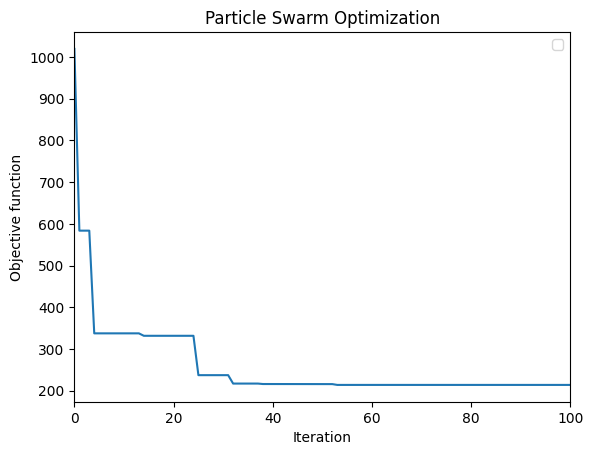

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: R$ 213,69
Tempo de Convergência para a segunda etapa: 1.3137929439544678 segundos


In [4132]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization')


# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", melhorCusto)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

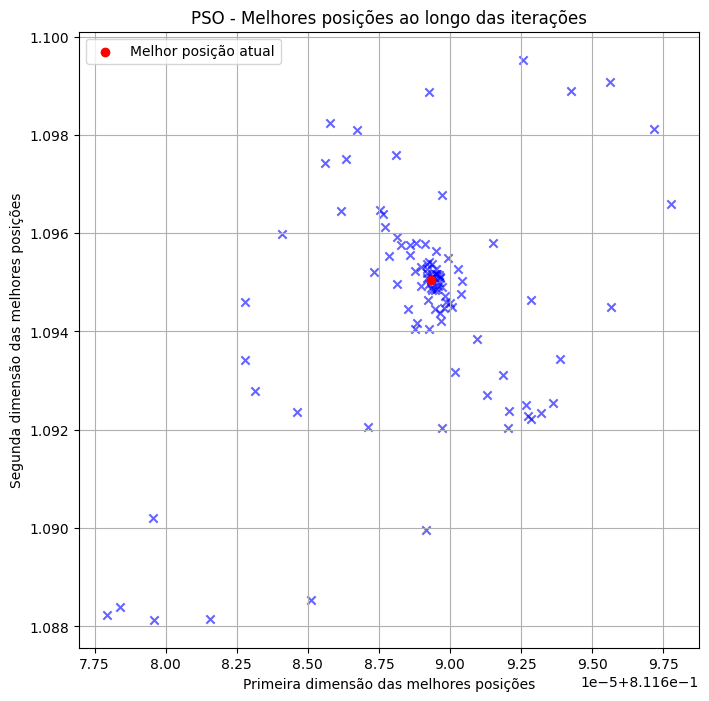

In [4133]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [4134]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [4135]:
# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(melhorCusto)  # Substitua pbest_cost[0] por best_cost

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), melhorCusto, lamb, beta, theta, convergence_time_first_stage, convergence_time_second_stage,]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)

In [4136]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,"R$ 213,69",148.82361,1.003177,0.659417,0.014063,1.200916,NaN
1,2,"R$ 213,47",148.82361,1.003177,0.659417,0.009366,1.162873,NaN
2,3,"R$ 214,08",148.82361,1.003177,0.659417,0.008394,1.313679,NaN
3,4,"R$ 237,10",148.82361,1.003177,0.659417,0.011445,1.297929,NaN
4,5,"R$ 215,85",148.82361,1.003177,0.659417,0.011161,1.394715,NaN
5,6,"R$ 213,43",148.82361,1.003177,0.659417,0.009453,1.354239,NaN
6,7,"R$ 213,48",148.82361,1.003177,0.659417,0.006884,1.337299,NaN
7,8,"R$ 213,43",148.82361,1.003177,0.659417,0.012637,0.836785,NaN
8,9,"R$ 213,53",148.82361,1.003177,0.659417,0.006800,0.969784,NaN
9,10,"R$ 213,69",148.82361,1.003177,0.659417,0.011978,1.313793,NaN


In [4137]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Index                        10 non-null     int64  
 1   Melhor_Custo                 10 non-null     object 
 2   Lambda                       10 non-null     float64
 3   Beta                         10 non-null     float64
 4   Theta                        10 non-null     float64
 5   Convergencia_Primeira_Etapa  10 non-null     float64
 6   Convergencia_Segunda_Etapa   10 non-null     float64
 7   Ciclos_MP                    0 non-null      float64
dtypes: float64(6), int64(1), object(1)
memory usage: 768.0+ bytes


In [4138]:
resultado.describe()

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
count,10.00000,10.00000,10.000000,1.000000e+01,10.000000,10.000000,0.0
mean,5.50000,148.82361,1.003177,6.594170e-01,0.010218,1.218201,NaN
std,3.02765,0.00000,0.000000,1.170278e-16,0.002439,0.182272,NaN
min,1.00000,148.82361,1.003177,6.594170e-01,0.006800,0.836785,NaN
25%,3.25000,148.82361,1.003177,6.594170e-01,0.008637,1.172384,NaN
50%,5.50000,148.82361,1.003177,6.594170e-01,0.010307,1.305804,NaN
75%,7.75000,148.82361,1.003177,6.594170e-01,0.011845,1.331422,NaN
max,10.00000,148.82361,1.003177,6.594170e-01,0.014063,1.394715,NaN


In [4139]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

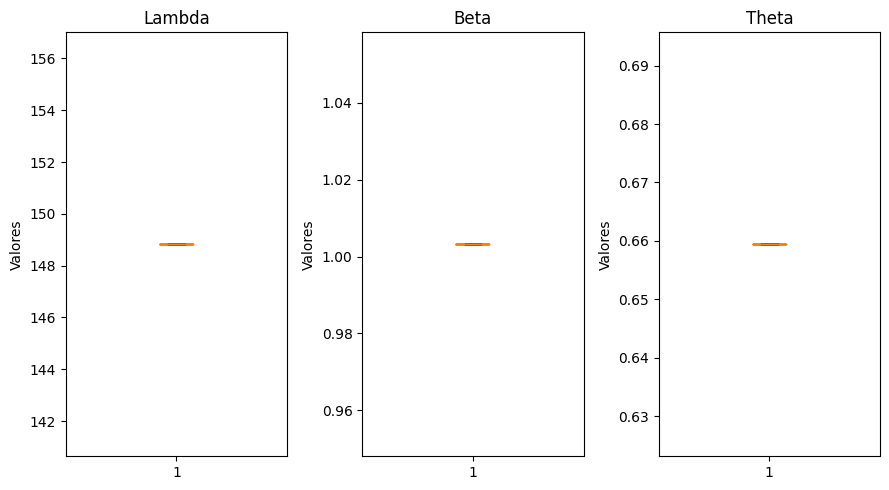

In [4140]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [4141]:
# # Cria uma grafico para os parameros da segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(param_segunda_etapa):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

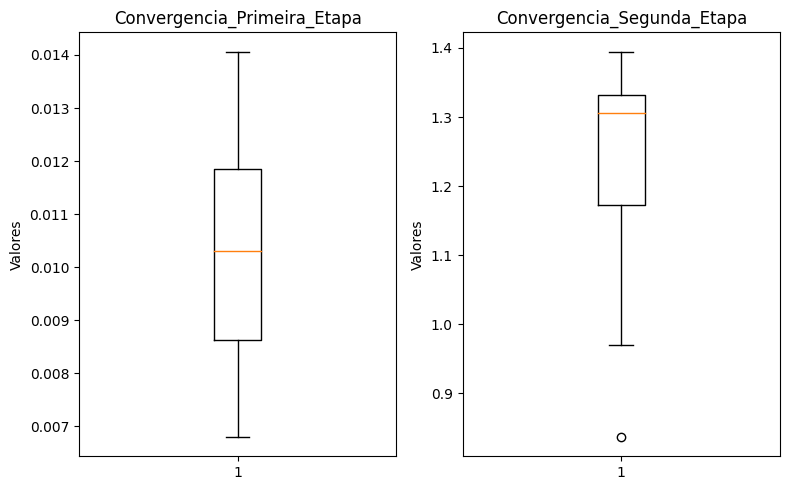

In [4142]:
# Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(convergencia):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [4143]:
# Arrays de tempos e severidade
Tempos = [
[[1022]],
[[691]],
[[1022]],
[[365]],
[[874]],
[[1053]],
[[1235]],
[[781]],
[[1380]],
[[210]],
]

severidade = [
    [[1.0]],
    [[1.0]],
    [[1.0]],
    [[1.0]],
    [[1.0]],
    [[1.0]],
    [[1.0]],
    [[1.0]],
    [[1.0]],
    [[1.0]],
]

# Verifica se ambos os arrays têm o mesmo número de linhas
if len(Tempos) == len(severidade):
    with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
        file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
        for i in range(len(Tempos)):
            row = Tempos[i] + severidade[i]
            row_str = [str(value) for value in row]
            file.write(f"{i};{';'.join(row_str)}\n")
else:
    print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [4144]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,[1022],[1.0]
1,[691],[1.0]
2,[1022],[1.0]
3,[365],[1.0]
4,[874],[1.0]
5,[1053],[1.0]
6,[1235],[1.0]
7,[781],[1.0]
8,[1380],[1.0]
9,[210],[1.0]


In [4145]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Tempos_Manutencoes_Preventivas  10 non-null     object
 1   Severidade_subsistema           10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


In [4146]:
dados.describe()

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
count,10,10
unique,9,1
top,[1022],[1.0]
freq,2,10
